# Notebook to make plots for figure 4

by Cascade Tuholske 2020.04.06

**Pick a city of geography & Year ... 1987-1988 W Africa, 1998 India & 2003 Europe** <br>
Cities : 12080 Hongcong, 9691 Kolkata, 8050 Bangalore, 1910 Accra, 2125 Lagos, 2046 Paris, 2987 Rome,
2559 Milan, 1887 bordeaux, 2135 Brussels, <br>

**We're using**
- 9691, Kolkata 1998
- 2046, Paris 2003
- 4417, Aleppo 2010


Helpful for julian days: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html

In [1]:
#### Dependencies
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates


In [3]:
def make_data(dir_in, geog, location):
    """Function makes data to plot daily city-level HI Max and average
    Args:
        dir_in = directory to get data
        geog = column for geography, city-level = 'ID_HDC_G0'
        location = usually a city id
    """
    
    fn_list = sorted(glob.glob(dir_in+'*.csv')) # get data
    df_out = pd.DataFrame() # to write dataframe
    
     # get leap year cols from 2016
    hi16 = pd.read_csv(fn_list[33]) 
    cols = list(hi16.iloc[:,3:].columns)
    cols = [year[5:] for year in cols] # cols for data frame
    
    temp_list = [] # empty list for temps
    
    # loop through dir and get data
    for i, fn in enumerate(fn_list):
        df = pd.read_csv(fn) # open data frame
        year_label = [(df.columns[3]).split('.')[0]] # get year
        row = df[df[geog] == location]
        temp = row.iloc[:,3:] # get only temp columns
        
        # add in col for leap years
        if temp.shape[1] == 365:
            temp.insert(loc = 59, column = year_label[0]+'.02.29', value = np.nan, allow_duplicates=False)

        # Set Index & Columns
        temp.index = year_label
        temp.columns = cols # revalue to m.d
    
        # add to list
        temp_list.append(temp)
    
    df_out = pd.concat(temp_list) # make one big dataframe
    
    return df_out
    

In [12]:
def plot_data(df, year, start, end):#, start, end):
    """ Make the data for a plot
    Args: 
        df = df w/ daily HI max for a given city
        year = year you want to plot against average
        start = start of plot in julian days (e.g 1 - 365/366)
        end = end of plot in julian days
    """

    # Deal with leap year
    if year % 4 !=0:
        df.drop(columns ='02.29', inplace = True)
    
    # Subset data
    start = start - 1 # zero indexing 
    subset = df.iloc[:,start:end]
    
    # HI Max for year
    hi_year = subset.loc[str(year)]
    
    # make 34-avg daily hi
    means = subset.mean(axis = 0)
    
    # make colums to date time
    cols = pd.to_datetime([str(year)+'.'+date for date in hi_year.index])
    
    return hi_year, means, cols


# One panel

In [86]:
#### Heat Index Data
data = 'HI'
DATA_IN = '/home/cascade/projects/UrbanHeat/data/interim/CHIRTS_DAILY/'+data+'/' # output from avg temp
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'
DS = u"\N{DEGREE SIGN}"
t = 40.6

In [87]:
# Args
#[3342, 'Cairo'] #[1910, 'Accra'] 3268, Cape Town
#[4417, 'Aleppo'] 2010 [2046, 'Paris'] 2003 [9691, 'Kolkata'] 1998 ['6955, Dehli']

# Args
city_list = [2046, 'Paris']
year = 2010
font_size = 10


# FN OUT
FN_OUT = 'FIG4-'+data+'-'+city_list[1]+str(year)+'.png' #

# April 1 to Sep 30 (Use Julian Days), or 1 - 182 lagos
start = 91 
end = 273

# Labels
hi_label = str(year)+' '+data
labels =  ['avg. '+data, hi_label, str(t)+''+DS+'C']  # <<<<<------------ Be sure to update! 

# Make Data 
df = make_data(DATA_IN, 'ID_HDC_G0', city_list[0])
years, means, cols = plot_data(df, year, start, end)

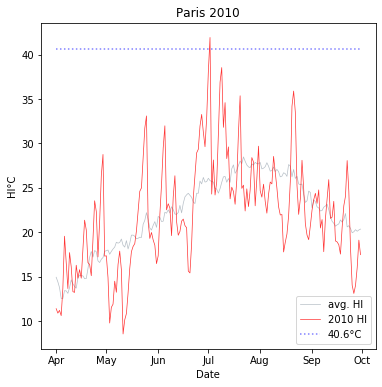

In [88]:
#### Make Figure & Save it

# Set up
rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig, axs = plt.subplots(1, 1, figsize = (6, 6), sharex=True) #(3, 2.247)
ws = 0.5
fig.subplots_adjust(hspace=ws)

#plot
axs.plot(cols, means, color = 'slategray', alpha = 0.5, linestyle = '-', lw = 0.7) # Long term daily avg
axs.plot(cols, years, color = 'red', alpha = 0.8, lw = 0.7) # Daily HI Max
axs.hlines(y = t, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs.set_title(city_list[1]+ ' '+ str(year))
axs.tick_params(axis='both', labelsize = 6)

# ticks
# Make ticks on occurrences of each month:
axs.xaxis.set_major_locator(mdates.MonthLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axs.tick_params(axis='both', labelsize = 10)
#axs.xaxis.set_major_locator(plt.MaxNLocator(3))

# Labels
#fig.text(0,0.5, 'Heat Index '+DS+'C', ha="center", va="center", rotation=90, fontsize = 8)
plt.ylabel(data+DS+'C', fontsize = 10)
plt.xlabel('Date', fontsize = 10)


# Legend
plt.legend(labels, loc=4, prop={'size': 10})

# Save it out
plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')